# MULTI-STRATEGY (ETFs OR FUNDS)

In [31]:
from __future__ import print_function
from IPython.utils.path import get_ipython_dir
print(get_ipython().profile_dir.location)

import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import itable
import ffn

from fintools.Parameters import Parameters
from fintools.set_start_end import set_start_end
from fintools.get_yahoo_prices import get_yahoo_prices
from fintools.compute_weights_RS_DM import compute_weights_RS_DM
from fintools.compute_weights_PMA import compute_weights_PMA
from fintools.endpoints import endpoints
from fintools.backtest import backtest
from fintools.monthly_return_table import monthly_return_table
from fintools.show_return_table import show_return_table
from fintools.finhelpers3 import highlight_pos_neg
from fintools import generate_orders

%matplotlib inline

/home/scubamut/.ipython/profile_default


# Portfolio Moving Average (PMA), Relative Strength (RS) and Dual Momentum (DM) Backtests

In [ ]:
# Define which online source one should use
data_source = 'yahoo'

# We would like all available data from 01/01/2000 until today.

start_date = '1986-01-01'
# start_date = '2000-01-01'
# end_date = '2016-12-31'
end_date = datetime.today().strftime('%Y-%m-%d')

In [44]:
# CHOOSE EITHER ETFs OR FUNDS

# ETFs

strategies = {
    'RS0001': { 'symbols': ['CWB','HYG','MBB','IEF','HYD'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 2, 'frequency': 'M',
              'cash_proxy': 'CASHX', 'risk_free': 0},
    'RS0002': {'symbols': ['HYD','QLTB','MBB'], 
               'prices':data_source, 'start':start_date, 'end':end_date,               
               'rs_lookback': 3, 'risk_lookback': 2, 'n_top': 1, 'frequency': 'M',
              'cash_proxy': 'CASHX', 'risk_free': 0},
    'RS0003': {'symbols': ['HYD','MBB','SHY'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 1, 'frequency': 'Q',
              'cash_proxy': 'CASHX', 'risk_free': 0},    
    'DM0001': {'symbols': ['CWB','VYM','HYG','VHT','TLT','MBB','HYD','IEF'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'M',
              'cash_proxy': 'CASHX', 'risk_free': 'SHY'},
    'DM0002': {'symbols': ['CWB','TLT','HYG','VHT','VNQ'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 5, 'frequency': 'M',
              'cash_proxy': 'MBB', 'risk_free': 'SHY'},
    'PMA001': {'symbols': ['CWB','MBB'], 
               'prices':data_source, 'start':start_date, 'end':end_date,  
               'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.4],
              'cash_proxy': 'TLT'},
    'PMA002': {'symbols': ['CWB','VYM','HYG'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.2, 0.2],
              'cash_proxy': 'TLT'},
    'PMA003': {'symbols': ['VCVSX', 'FAGIX', 'VGHCX'], 
               'prices':data_source, 'start':start_date, 'end':end_date,
               'risk_lookback': 2, 'frequency': 'M', 'allocations': [1./3., 1./3., 1./3.],
              'cash_proxy': 'VUSTX'}
    }

# FUNDS

# strategies = {
#     'RS0001': { 'symbols': ['VCVSX','VWEHX','VFIIX','FGOVX','VWAHX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 2, 'frequency': 'M',
#               'cash_proxy': 'CASHX', 'risk_free': 0},
#     'RS0002': {'symbols': ['MMHYX','FAGIX','VFIIX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,               
#                'rs_lookback': 3, 'risk_lookback': 2, 'n_top': 1, 'frequency': 'M',
#               'cash_proxy': 'CASHX', 'risk_free': 0},
#     'RS0003': {'symbols': ['MMHYX','FAGIX','VFIIX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 1, 'frequency': 'Q',
#               'cash_proxy': 'CASHX', 'risk_free': 0},    
#     'DM0001': {'symbols': ['VCVSX','VWINX','VWEHX','VGHCX','VUSTX','VFIIX','VWAHX','FGOVX','FFXSX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 3, 'frequency': 'M',
#               'cash_proxy': 'CASHX', 'risk_free': 'FFXSX'},
#     'DM0002': {'symbols': ['VCVSX','VUSTX','VWEHX','VFIIX','VGHCX','FRESX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'rs_lookback': 1, 'risk_lookback': 1, 'n_top': 5, 'frequency': 'M',
#               'cash_proxy': 'VFIIX', 'risk_free': 'FFXSX'},
#     'PMA001': {'symbols': ['VCVSX', 'VFIIX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,  
#                'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.4],
#               'cash_proxy': 'VUSTX'},
#     'PMA002': {'symbols': ['VCVSX', 'VWINX', 'VWEHX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'risk_lookback': 3, 'frequency': 'M', 'allocations': [0.6, 0.2, 0.2],
#               'cash_proxy': 'VUSTX'},
#     'PMA003': {'symbols': ['VCVSX', 'FAGIX', 'VGHCX'], 
#                'prices':data_source, 'start':start_date, 'end':end_date,
#                'risk_lookback': 2, 'frequency': 'M', 'allocations': [1./3., 1./3., 1./3.],
#               'cash_proxy': 'VUSTX'}
#     }

In [45]:
# strategy_values = pd.DataFrame(columns=strategies.keys())
strategy_values = {}
security_weights = {}
security_holdings = {}
prices = {}

for name in strategies :
    if 'PMA' in name :
        try:
            s_value, s_holdings, s_weights, s_prices =  compute_weights_PMA (name, strategies[name])
        except:
            print ('*** Unable to use PMA strategy : ' + name)
            name = 'None'
    else :
        try:
            s_value, s_holdings, s_weights, s_prices =  compute_weights_RS_DM (name, strategies[name])
        except:
            print ('*** Unable to use RS_DM strategy : ' + name)
            name = 'None'
            
    if name != 'None':
        strategy_values[name] = s_value
        security_weights[name] = s_weights
        security_holdings[name] = s_holdings
        prices[name] = s_prices

Strategy : RS0001
FIRST BUY DATE = 2009-05-29 00:00:00

Strategy : RS0002
*** Unable to use RS_DM strategy : RS0002
Strategy : RS0003
FIRST BUY DATE = 2009-05-29 00:00:00

Strategy : DM0001
FIRST BUY DATE = 2009-05-29 00:00:00

Strategy : DM0002
FIRST BUY DATE = 2009-05-29 00:00:00

PMA001
FIRST BUY DATE = 2009-06-30 00:00:00

PMA002
FIRST BUY DATE = 2009-06-30 00:00:00

PMA003
FIRST BUY DATE = 1986-07-31 00:00:00



In [46]:
columns = list(strategy_values.keys())
columns

['RS0001', 'RS0003', 'DM0001', 'DM0002', 'PMA001', 'PMA002', 'PMA003']

In [47]:
strategy_values = pd.DataFrame(strategy_values).dropna()
index = strategy_values.index
rebalance_dates = endpoints(period='M', trading_days=index)

In [49]:
# find the set of all portfolio symbols
n = len(columns)
l = [list(security_weights[name].columns) for name in columns]
s = []
for i in range(n) :
    s = s + l[i]
    
aggregated_weights = pd.DataFrame(0, index=rebalance_dates, columns=list(set(s)))
all_prices = pd.DataFrame(0, index=index, columns=list(set(s)))
aggregated_weights[:1]

,CWB,VCVSX,VGHCX,HYG,HYD,VNQ,FAGIX,VUSTX,IEF,CASHX,VHT,TLT,SHY,MBB,VYM
2009-06-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
# for equally weighted strategies
strategy_weights = pd.Series([1. / n for i in range(n)], index=columns)
strategy_weights

RS0001    0.142857
RS0003    0.142857
DM0001    0.142857
DM0002    0.142857
PMA001    0.142857
PMA002    0.142857
PMA003    0.142857
dtype: float64

In [51]:
for name in columns :
    aggregated_weights[security_weights[name].columns] += security_weights[name].loc[rebalance_dates] * strategy_weights[name]
    all_prices = prices[name].loc[index].combine_first(all_prices)

In [52]:
aggregated_weights[:3].round(3)

,CWB,VCVSX,VGHCX,HYG,HYD,VNQ,FAGIX,VUSTX,IEF,CASHX,VHT,TLT,SHY,MBB,VYM
2009-06-30,0.319,0.048,0.048,0.176,0.143,0.000,0.048,0.0,0.0,0.0,0.076,0.029,0.0,0.086,0.029
2009-07-31,0.319,0.048,0.048,0.176,0.143,0.029,0.048,0.0,0.0,0.0,0.029,0.029,0.0,0.057,0.076
2009-08-31,0.319,0.048,0.048,0.029,0.262,0.029,0.048,0.0,0.0,0.0,0.029,0.029,0.0,0.086,0.076


In [53]:
# from backtest_helpers.backtest import backtest
p_value, p_holdings, p_weights = backtest(all_prices, aggregated_weights, 10000., offset=0, commission=10.)

FIRST BUY DATE = 2009-06-30 00:00:00



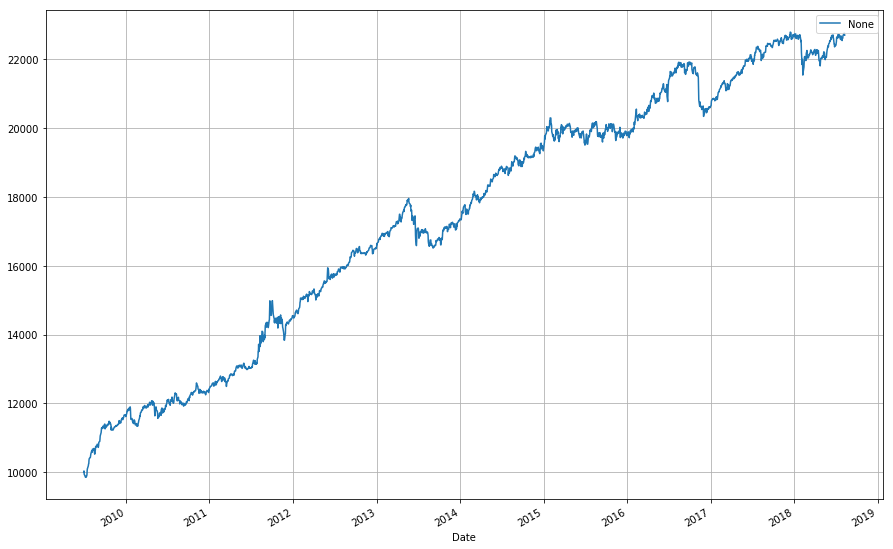

In [54]:
p_value.plot(figsize=(15,10), grid=True, legend=True)

In [55]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2009-06-30 00:00:00 - 2018-08-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
127.04%             1.48  9.42%   -8.04%

Annualized Returns:
mtd    3m     6m     ytd    1y     3y     5y     10y    incep.
-----  -----  -----  -----  -----  -----  -----  -----  --------
0.33%  2.39%  5.09%  0.05%  3.36%  4.25%  6.00%  9.42%  9.42%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.48     1.52       1.41
mean    9.20%    9.16%      7.86%
vol     6.22%    6.04%      5.56%
skew    -0.31    0.25       0.28
kurt    3.54     1.79       -0.83
best    2.17%    6.46%      17.11%
worst   -2.17%   -5.00%     0.05%

Drawdowns:
max     avg       # days
------  ------  --------
-8.04%  -0.90%     19.31

Misc:
---------------  -------
avg. up month    1.51%
avg. down month  -1.31%
up year %        100.00%
12m up %         99.00%
------

In [56]:
def highlight_pos_neg (s) :
    is_positive = s > 0    
    return ['background-color : rgb(127,255,0)' if v else 'background-color : rgb(255,99,71)' for v in is_positive]

df = monthly_return_table (p_value)

df.style.\
    apply(highlight_pos_neg)

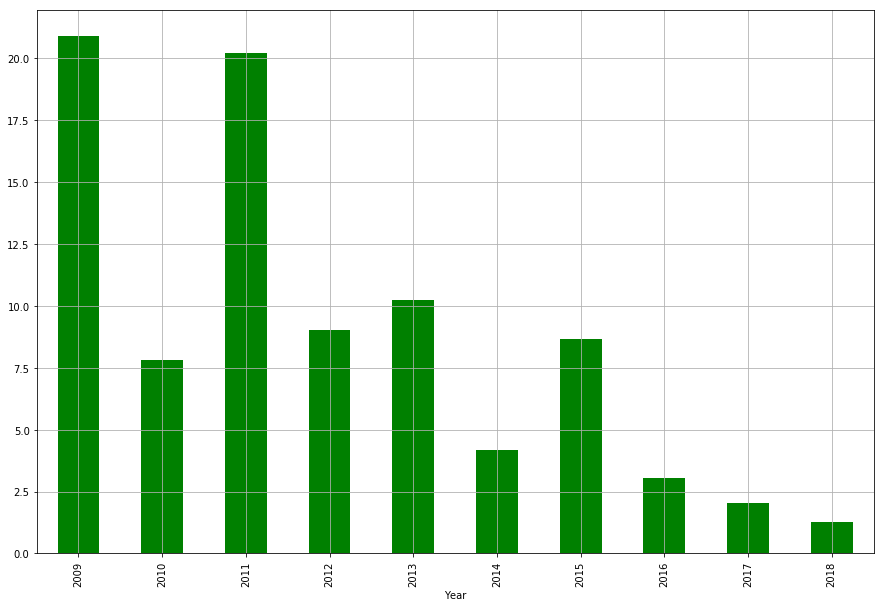

In [57]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

### Need to determine the holdings of each security

In [58]:
p_holdings.loc[rebalance_dates].round(0)[:5]

,CASHX,CWB,FAGIX,HYD,HYG,IEF,MBB,SHY,TLT,VCVSX,VGHCX,VHT,VNQ,VUSTX,VYM
Date,,,,,,,,,,,,,,,
2009-06-30,0.0,150.0,120.0,84.0,40.0,0.0,10.0,0.0,4.0,76.0,9.0,19.0,0.0,0.0,12.0
2009-07-31,0.0,148.0,115.0,87.0,39.0,0.0,7.0,0.0,4.0,75.0,9.0,7.0,12.0,0.0,31.0
2009-08-31,0.0,147.0,115.0,158.0,7.0,0.0,11.0,0.0,4.0,75.0,9.0,7.0,11.0,0.0,30.0
2009-09-30,0.0,116.0,113.0,151.0,41.0,0.0,8.0,0.0,4.0,76.0,9.0,7.0,11.0,0.0,11.0
2009-10-30,1873.0,80.0,111.0,83.0,7.0,0.0,42.0,0.0,4.0,0.0,0.0,0.0,0.0,145.0,0.0


In [59]:
transactions = (p_holdings - p_holdings.shift(1).fillna(0))
transactions = transactions[transactions.sum(1) != 0]
transactions.round(0)[:5]

,CASHX,CWB,FAGIX,HYD,HYG,IEF,MBB,SHY,TLT,VCVSX,VGHCX,VHT,VNQ,VUSTX,VYM
Date,,,,,,,,,,,,,,,
2009-06-30,0.0,150.0,120.0,84.0,40.0,0.0,10.0,0.0,4.0,76.0,9.0,19.0,0.0,0.0,12.0
2009-07-31,0.0,-2.0,-4.0,3.0,-1.0,0.0,-3.0,0.0,0.0,-1.0,0.0,-12.0,12.0,0.0,19.0
2009-08-31,0.0,-1.0,-0.0,71.0,-32.0,0.0,4.0,0.0,0.0,0.0,-0.0,0.0,-1.0,0.0,-1.0
2009-09-30,0.0,-32.0,-2.0,-7.0,34.0,0.0,-3.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,-18.0
2009-10-30,1873.0,-36.0,-2.0,-68.0,-34.0,0.0,35.0,0.0,0.0,-76.0,-9.0,-7.0,-11.0,145.0,-11.0


In [60]:
# del transactions['CASHX']
orders = generate_orders(transactions, all_prices)
orders[:10]

,Year,Month,Day,Symbol,Action,Qty,Price
0,2009,6,30,CWB,Buy,149.812639,21.296442
0,2009,6,30,FAGIX,Buy,119.532411,3.983777
0,2009,6,30,HYD,Buy,83.723524,17.062963
0,2009,6,30,HYG,Buy,39.623735,44.465893
0,2009,6,30,MBB,Buy,10.474863,81.828552
0,2009,6,30,TLT,Buy,3.979644,71.793930
0,2009,6,30,VCVSX,Buy,76.061428,6.260604
0,2009,6,30,VGHCX,Buy,8.679874,54.861450
0,2009,6,30,VHT,Buy,18.948043,40.210209
0,2009,6,30,VYM,Buy,11.803699,24.205486


### Let's look at some more recent performance

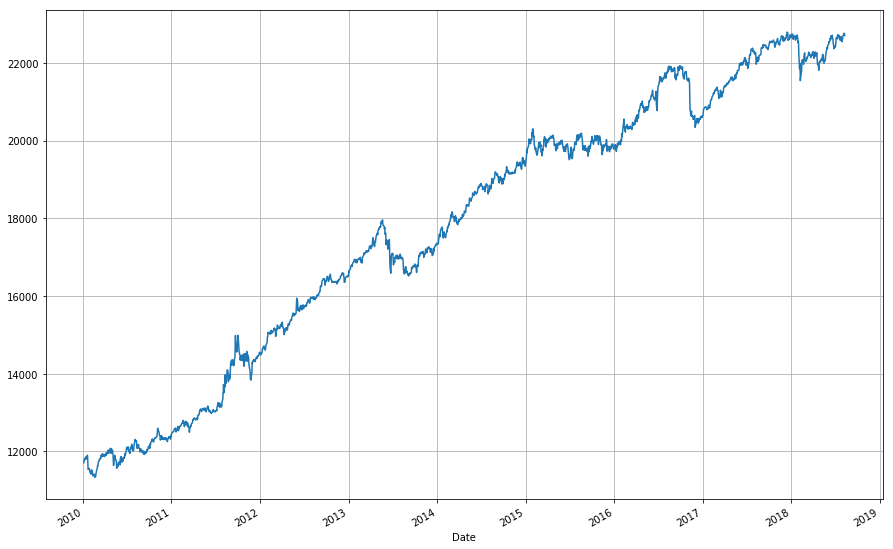

In [61]:
import datetime as dt
p_value[p_value.index > dt.datetime(2010,1,1)].plot(figsize=(15,10), grid=True)

#### What about using downside protection?

In [62]:
cash_proxy = 'SHY'
risk_free = 'SHY'

if risk_free == 'CASHX' :
    px = pd.DataFrame (columns=list(set([cash_proxy, risk_free])))
    tickers = [cash_proxy]
elif isinstance (risk_free, str) :
    px =  pd.DataFrame (columns=list(set([cash_proxy, risk_free])))
    tickers = [cash_proxy, risk_free]
else :
    px = pd.DataFrame (columns=[cash_proxy])

prices = strategy_values.copy().dropna()
prices = prices / prices.iloc[0]
for symbol in tickers :
#     url = 'http://chart.finance.yahoo.com/table.csv?s=' + symbol + '&ignore=.csv'
#     prices[symbol] = pd.read_csv(url, parse_dates=True, index_col='Date').sort_index(ascending=True)['Adj Close'] 
       prices[symbol] = web.DataReader(tickers, data_source, start_date, end_date)['Adj Close']
prices = prices.dropna()
symbols = prices.columns

In [63]:
prices[:3]

,DM0001,DM0002,PMA001,PMA002,PMA003,RS0001,RS0003,SHY
Date,,,,,,,,
2009-06-30,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,77.666046
2009-07-01,1.002524,1.001463,1.003752,1.004570,1.003711,1.003787,1.005270,77.742241
2009-07-02,0.986448,0.992322,1.000071,0.992186,0.992113,0.991920,1.002725,77.825836


            DM0001  DM0002  PMA001  PMA002  PMA003  RS0001  RS0003    SHY
Date                                                                     
2009-07-31   0.125   0.125   0.125   0.125   0.125   0.125   0.125  0.125
2009-08-31   0.125   0.125   0.125   0.125   0.125   0.125   0.125  0.125
2009-09-30   0.125   0.125   0.125   0.125   0.125   0.125   0.125  0.125
2009-10-30   0.000   0.000   0.000   0.000   0.000   0.000   0.000  1.000
2009-11-30   0.125   0.125   0.125   0.125   0.125   0.125   0.000  0.250
FIRST BUY DATE = 2009-07-31 00:00:00



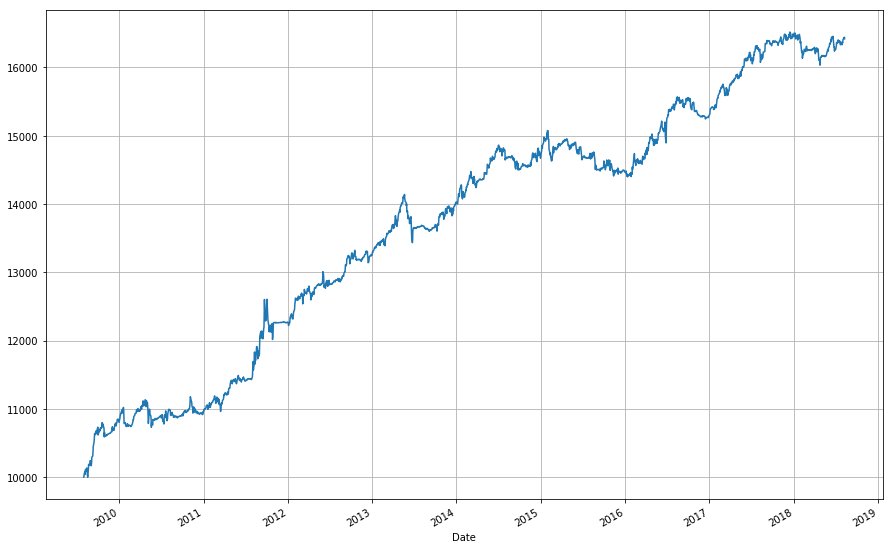

In [64]:
rs_lookback = 1
risk_lookback = 1
n_top = len(symbols)

frequency = 'M'

end_points = endpoints(period=frequency, trading_days=prices.index)
prices_m = prices.loc[end_points]

returns = prices_m[symbols].pct_change(rs_lookback)[rs_lookback:]
absolute_momentum_rule = returns > 0

if isinstance(risk_free, int) :
    excess_returns = returns
else :
    risk_free_returns =  prices_m[risk_free].pct_change(rs_lookback)[rs_lookback:]
    excess_returns = returns.subtract(risk_free_returns, axis=0).dropna()

rebalance_dates = excess_returns.index.join(absolute_momentum_rule.index, how='inner')

# relative strength ranking               
ranked = excess_returns.loc[rebalance_dates][symbols].rank(ascending=False, axis=1, method='dense')
# elligibility rule - top n_top ranked securities
elligible = ranked[ranked<=n_top] > 0

# equal weight allocations
elligible = elligible.multiply(1./elligible.sum(1), axis=0)

# downside protection
weights = pd.DataFrame(0.,index=elligible.index, columns=prices.columns)
if cash_proxy == 'CASHX' :
    weights[cash_proxy] = 0
    prices[cash_proxy] = 1.
weights[symbols] = (elligible * absolute_momentum_rule).dropna() 
weights[cash_proxy] += 1 - weights[symbols].sum(axis=1)

print (weights[:5])

# backtest

p_value, p_holdings, p_weights = backtest(prices, weights, 10000., offset=0, commission=10.)

p_value.plot(figsize=(15,10), grid=True)

The CAGR has dropped slightly but the Sharpe Ratio has increased significantly and the Max Drawdown has been reduced

In [65]:
# algo stats
ffn.calc_perf_stats(p_value).display()

Stats for None from 2009-07-31 00:00:00 - 2018-08-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
64.19%              1.31  5.65%   -5.00%

Annualized Returns:
mtd    3m     6m     ytd     1y     3y     5y     10y    incep.
-----  -----  -----  ------  -----  -----  -----  -----  --------
0.32%  1.54%  1.57%  -0.32%  2.15%  3.82%  3.73%  5.65%  5.65%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.31     1.39       1.13
mean    5.59%    5.55%      4.84%
vol     4.26%    3.98%      4.30%
skew    -0.06    1.25       0.01
kurt    5.33     4.81       -0.57
best    1.91%    5.64%      11.98%
worst   -1.52%   -1.97%     -1.38%

Drawdowns:
max     avg       # days
------  ------  --------
-5.00%  -0.67%     23.63

Misc:
---------------  ------
avg. up month    0.91%
avg. down month  -0.76%
up year %        77.78%
12m up %         89.90%
----

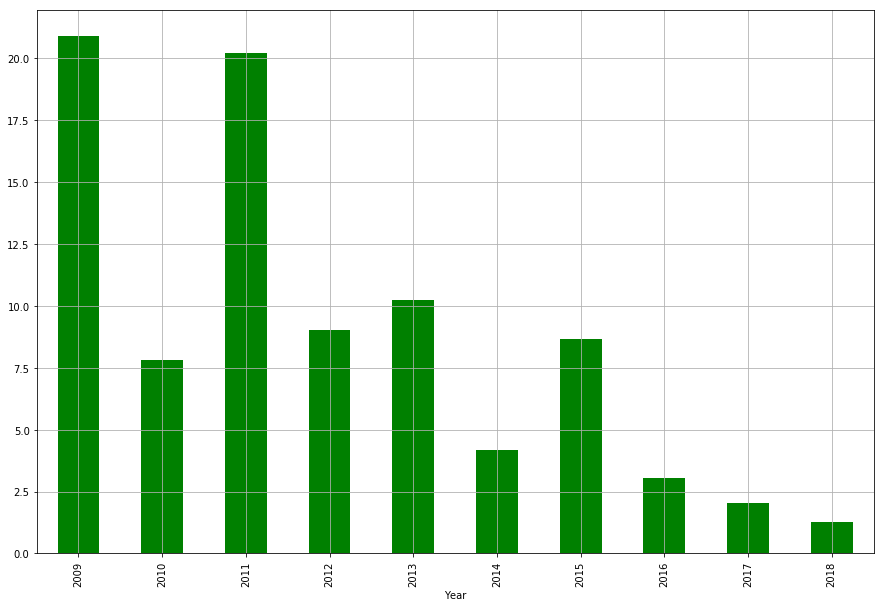

In [66]:
frame = df['Annual Returns'].to_frame()
frame['positive'] = df['Annual Returns'] >= 0
frame['Annual Returns'].plot(figsize=(15,10),kind='bar',color=frame.positive.map({True: 'g', False: 'r'}), grid=True)

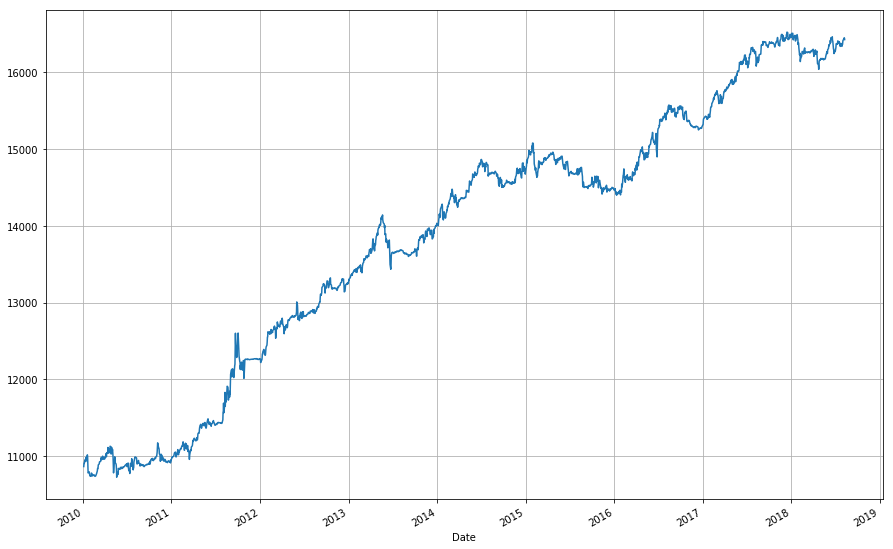

In [67]:
p_value[p_value.index > dt.datetime(2010,1,1)].plot(figsize=(15,10), grid=True)

In [68]:
p_holdings.loc[rebalance_dates].round(0)[:5]

,DM0001,DM0002,PMA001,PMA002,PMA003,RS0001,RS0003,SHY
Date,,,,,,,,
2009-07-31,1174.0,1200.0,1198.0,1168.0,1169.0,1171.0,1234.0,16.0
2009-08-31,1177.0,1180.0,1202.0,1166.0,1160.0,1190.0,1217.0,16.0
2009-09-30,1166.0,1199.0,1224.0,1172.0,1161.0,1163.0,1157.0,17.0
2009-10-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,135.0
2009-11-30,1167.0,1203.0,1183.0,1143.0,1147.0,1162.0,0.0,34.0


this is not very helpful - we need to know what to order at each rebalance date

In [69]:
p_weights.loc[rebalance_dates].round(3)[:5]

,DM0001,DM0002,PMA001,PMA002,PMA003,RS0001,RS0003,SHY
Date,,,,,,,,
2009-07-31,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2009-08-31,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2009-09-30,0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125
2009-10-30,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
2009-11-30,0.125,0.125,0.125,0.125,0.125,0.125,0.000,0.250
